In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from feature_vae import FeatureVAE
from FVAE_helper import GradientReversalLayer, SimpleRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from encoders import USEEncode, CLIPEncode, W2VEncode

/Users/thomas/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
non_given_dims = 12

rgb_supervise = False
rgb_supervise_start_epoch = 2
rgb_lambda = 2
    
    
adversarial_supervise = True
adversarial_lambda = 30
adversarial_target_language = True
adversarial_extra_train = 5

extra_reducer = False
extra_reducer_dim = 4

encoder_class = CLIPEncode
encoder_prompt = 'a {} colored shape'
encoder_model = None

beta = 1.0

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3
grad_clip = 1.0

updates_per_epoch = 1
num_displays = 3

In [3]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
shapes_meta = pd.read_csv('shapes.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,pentagon,deep teal,0.000000,0.333333,0.352941,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,NaN,False
1,pentagon,ruby,0.792157,0.003922,0.278431,1.443060,1.443060,176.249624,0.0,12.474021,22.318936,NaN,False
2,rectangle,indigo blue,0.227451,0.094118,0.694118,1.144956,1.416463,0.000000,0.0,0.000000,0.000000,NaN,False
3,pentagon,maize,0.956863,0.815686,0.329412,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,NaN,False
4,rectangle,wine,0.501961,0.003922,0.247059,1.000000,1.000000,0.000000,0.0,-2.050478,29.824324,-,False


In [6]:
resize = transforms.Resize(64)
shapes = resize(torch.load('shapes.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

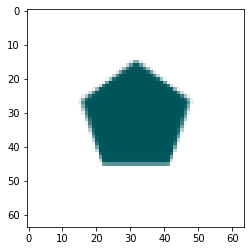

In [7]:
plt.imshow(shapes[0].permute(1, 2, 0).cpu())

In [8]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
del shapes

In [9]:
train_color_rgb = torch.FloatTensor(train_meta.iloc[:, 2:5].values)
valid_color_rgb = torch.FloatTensor(valid_meta.iloc[:, 2:5].values)

In [24]:
encoder_class is CLIPEncode

True

In [10]:
if encoder_class is CLIPEncode:
    train_meta = torch.load('shapes_clip.pt')
    train_meta, valid_meta = train_meta[:18000], train_meta[18000:]
else:
    text_encoder = encoder_class(encoder_model, encoder_prompt)

    train_meta = text_encoder.encode(train_meta)
    valid_meta = text_encoder.encode(valid_meta)

100%|██████████| 10/10 [03:07<00:00, 18.74s/it]


In [11]:
train_meta.shape

torch.Size([18000, 512])

In [12]:
# from sklearn.decomposition import KernelPCA, PCA
# dim_reducer = KernelPCA(n_components=200, kernel='cosine') #rbf, cosine, poly, linear
# # dim_reducer = PCA(n_components=100
# train_meta = torch.FloatTensor(dim_reducer.fit_transform(train_meta))
# valid_meta = torch.FloatTensor(dim_reducer.transform(valid_meta))
# train_meta.shape

In [13]:
num_features = train_meta.size(1)
num_features

512

In [14]:
# Does pretty good:
# adversarial_supervise = True
# adversarial_lambda = 20
# adversarial_target_language = False
# non_given_dims = 12, beta=1.0
# no grad clipping ? 

In [15]:
from torch.utils.data import Dataset

bce_loss = nn.BCELoss(reduction='sum')
mse_loss = nn.MSELoss()
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision, rgb):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
        self.rgb = rgb
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return self.imgs[idx].to(device), self.latent_supervision[idx].to(device), self.rgb[idx].to(device)

Epoch 1: 100%|█████████▉| 281/282 [02:40<00:00,  1.74it/s]

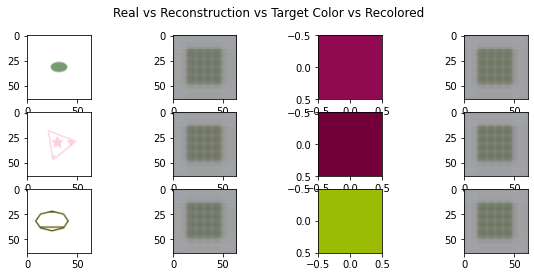

Epoch 1 | train loss 3370585197247019876352.00 | valid loss inf: 100%|██████████| 282/282 [02:44<00:00,  1.72it/s]
Epoch 2: 100%|█████████▉| 281/282 [02:41<00:00,  1.73it/s]

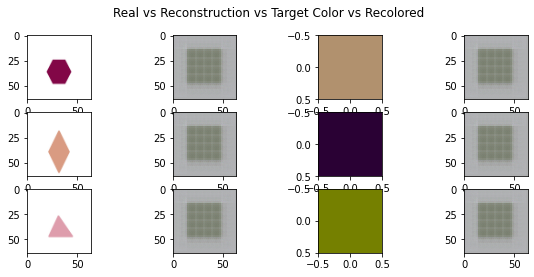

Epoch 2 | train loss 261385279411497326104312545280.00 | valid loss inf: 100%|██████████| 282/282 [02:44<00:00,  1.71it/s]
Epoch 3: 100%|█████████▉| 281/282 [02:47<00:00,  1.73it/s]

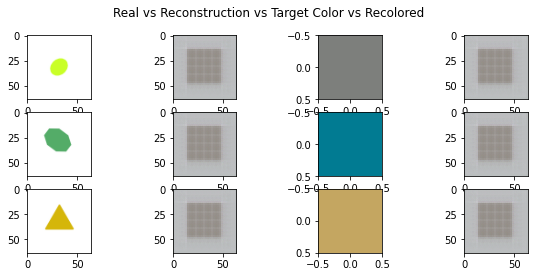

Epoch 3 | train loss 2523885859600913784587274944512.00 | valid loss inf: 100%|██████████| 282/282 [02:50<00:00,  1.65it/s]
Epoch 4:  87%|████████▋ | 246/282 [02:22<00:23,  1.54it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  88%|████████▊ | 247/282 [02:22<00:20,  1.67it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  88%|████████▊ | 248/282 [02:23<00:19,  1.77it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  88%|████████▊ | 249/282 [02:23<00:18,  1.83it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  89%|████████▊ | 250/282 [02:24<00:17,  1.88it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  89%|████████▉ | 251/282 [02:24<00:16,  1.92it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  89%|████████▉ | 252/282 [02:25<00:15,  1.95it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  90%|████████▉ | 253/282 [02:25<00:14,  1.99it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  90%|█████████ | 254/282 [02:26<00:13,  2.00it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  90%|█████████ | 255/282 [02:26<00:13,  1.98it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  91%|█████████ | 256/282 [02:27<00:13,  1.97it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  91%|█████████ | 257/282 [02:27<00:12,  1.99it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  91%|█████████▏| 258/282 [02:28<00:12,  1.99it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  92%|█████████▏| 259/282 [02:28<00:11,  2.01it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  92%|█████████▏| 260/282 [02:29<00:10,  2.01it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  93%|█████████▎| 261/282 [02:29<00:10,  2.01it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  93%|█████████▎| 262/282 [02:30<00:09,  2.03it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  93%|█████████▎| 263/282 [02:30<00:09,  2.01it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  94%|█████████▎| 264/282 [02:31<00:08,  2.02it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  94%|█████████▍| 265/282 [02:31<00:08,  1.99it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  94%|█████████▍| 266/282 [02:32<00:08,  2.00it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  95%|█████████▍| 267/282 [02:32<00:07,  2.02it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  95%|█████████▌| 268/282 [02:33<00:06,  2.00it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  95%|█████████▌| 269/282 [02:33<00:06,  2.01it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  96%|█████████▌| 270/282 [02:34<00:05,  2.01it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  96%|█████████▌| 271/282 [02:34<00:05,  2.01it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  96%|█████████▋| 272/282 [02:35<00:05,  1.99it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  97%|█████████▋| 273/282 [02:35<00:04,  1.99it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  97%|█████████▋| 274/282 [02:36<00:04,  2.00it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  98%|█████████▊| 275/282 [02:36<00:03,  1.98it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  98%|█████████▊| 276/282 [02:37<00:02,  2.01it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  98%|█████████▊| 277/282 [02:37<00:02,  2.02it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  99%|█████████▊| 278/282 [02:38<00:01,  2.02it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  99%|█████████▉| 279/282 [02:38<00:01,  2.00it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4:  99%|█████████▉| 280/282 [02:39<00:00,  2.00it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4: 100%|█████████▉| 281/282 [02:39<00:00,  1.98it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


Epoch 4: 100%|█████████▉| 281/282 [02:39<00:00,  1.76it/s]

tensor(1.)
tensor(nan, grad_fn=<MaxBackward1>)


RuntimeError: all elements of input should be between 0 and 1

In [16]:
from torch.utils.data import DataLoader

extra_params = []

if extra_reducer:
    reducer = SimpleRegressor(num_features, extra_reducer_dim).to(device)
    num_features = extra_reducer_dim
    extra_params.extend(list(reducer.parameters()))


if rgb_supervise:
    z_dim = 3 + non_given_dims
else:
    z_dim = num_features + non_given_dims    

net = FeatureVAE(z_dim, 3 if rgb_supervise else num_features)
net = net.to(device)
extra_params.extend(list(net.parameters()))

if rgb_supervise:
    rgb_maker = SimpleRegressor(num_features, 3).to(device)
    extra_params.extend(list(rgb_maker.parameters()))
    
if adversarial_supervise:
    adversary = SimpleRegressor(non_given_dims, 
                                num_features if adversarial_target_language else 3).to(device)
#     extra_params.extend(list(adversary.parameters()))
    adv_optimizer = torch.optim.Adam(adversary.parameters(), lr=lr)
    GRL = GradientReversalLayer.apply

# optimizer = torch.optim.AdamW(extra_params, lr=lr)
optimizer = torch.optim.Adam(extra_params, lr=lr)

train_dataloader = DataLoader(DatasetWrapper(train, train_meta, train_color_rgb), batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(DatasetWrapper(valid, valid_meta, train_color_rgb), batch_size=batch_size, shuffle=True)


num_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)


train_losses, valid_losses = [], []

rgb_losses, adversary_losses = [], []

update_idxs = set([i * (num_batches // updates_per_epoch)
    for i in range(1, updates_per_epoch)] + [num_batches])

best_valid = 1e9
for epoch in range(1, 1+num_epochs):
    total_loss = 0.0 

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=True, total=num_batches)
    
    if adversarial_supervise and adversarial_extra_train:
        adversary_extra_loader = iter(train_dataloader)
    
    for idx, (x, latent_supervision, rgb) in enumerate(pbar, start=1):
        
        # extra training runs for adversary
        if adversarial_supervise and adversarial_extra_train:
            for _ in range(adversarial_extra_train):
                batch = next(adversary_extra_loader, None)
                if batch is None:
                    adversary_extra_loader = iter(train_dataloader)
                    batch = next(adversary_extra_loader, None)
                
                x2, latent_supervision2, rgb2 = batch
                
                if extra_reducer:
                    latent_supervision2 = reducer(latent_supervision2)
                    
                with torch.no_grad():
                    supervision = latent_supervision2
                    if rgb_supervise:
                        pred_rgb = rgb_maker(latent_supervision2)
                        supervision = rgb2 if epoch < rgb_supervise_start_epoch else pred_rgb
                    recon, mu, var, z = net(x2, supervision)
                    
                adv_optimizer.zero_grad()
                pred_target = adversary(z.detach())
                loss = adversarial_lambda * mse_loss(pred_target, 
                            latent_supervision2 if adversarial_target_language else rgb2)
                loss.backward()
                adv_optimizer.step()
        
        # main train loop
        optimizer.zero_grad()
        
        if extra_reducer:
            latent_supervision = reducer(latent_supervision)
            
        supervision = latent_supervision
        loss = 0.0
        if rgb_supervise:
            pred_rgb = rgb_maker(latent_supervision)
            loss = loss + rgb_lambda * mse_loss(pred_rgb, rgb)
            supervision = rgb if epoch < rgb_supervise_start_epoch else pred_rgb
        
        recon, mu, var, z = net(x, supervision)
        try:
            loss += vae_loss(x, mu, var, recon, beta)
        except:
            print(x.max())
            print(recon.max())
        
        if adversarial_supervise:
            pred_target = adversary(GRL(z))
            loss = loss + adversarial_lambda * mse_loss(pred_target, 
                            latent_supervision if adversarial_target_language else rgb)

        total_loss += loss.item() / gradient_accumulation_steps
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
#         if (idx % gradient_accumulation_steps == 0) or (idx == num_batches):
#             nn.utils.clip_grad_norm_(extra_params, grad_clip)
        optimizer.step()

        if idx in update_idxs:
            avg_valid_loss = 0.0
            
            avg_adversary_loss, avg_rgb_loss = 0.0, 0.0
            
            displays = []
            net.eval()
            with torch.no_grad():
                for (x, latent_supervision, rgb) in valid_dataloader:
                    
                    if extra_reducer:
                        latent_supervision = reducer(latent_supervision)
                        
                    supervision = latent_supervision
                    
                    if rgb_supervise:
                        pred_rgb = rgb_maker(latent_supervision)
                        avg_rgb_loss += mse_loss(pred_rgb, rgb).item() / num_valid_batches
                        supervision = pred_rgb
                        
                    recon, mu, var, z = net(x, supervision)
                    
                    if adversarial_supervise:
                        avg_adversary_loss += mse_loss(adversary(z), 
                        latent_supervision if adversarial_target_language else rgb).item() / num_valid_batches
                    
                    avg_valid_loss += vae_loss(x, mu, var, recon, beta).item() / num_valid_batches
                    if not displays:
                        net.random_z = tuple(z[0].detach().cpu().numpy())
                        
                        rand_color_idxs = np.random.randint(len(valid_color_rgb), size=num_displays)
                        rand_colors = valid_color_rgb[rand_color_idxs].cpu().numpy()
                        
                        rand_color_features = valid_meta[rand_color_idxs].to(device)
                        if extra_reducer:
                            rand_color_features = reducer(rand_color_features)
                        
                        if rgb_supervise:
                            rand_color_features = rgb_maker(rand_color_features)
                        
                        recon2 = net.generate(z[:num_displays], rand_color_features)
                        
                        for j in range(num_displays):
                            displays.append((
                                x[j].permute(1, 2, 0).cpu().numpy(),
                                recon[j].permute(1, 2, 0).cpu().numpy(),
                                rand_colors[j][None, None, :],
                                recon2[j].permute(1, 2, 0).cpu().numpy()
                            )
                            )
                
                if avg_valid_loss < best_valid:
                    torch.save(net, f'models/{beta}-featurevae-{z_dim}dim')
                    best_valid = avg_valid_loss
                    
                valid_losses.append(avg_valid_loss)
                rgb_losses.append(avg_rgb_loss)
                adversary_losses.append(avg_adversary_loss)
                
                if idx == num_batches:
                    fig, axes = plt.subplots(num_displays, 4)
                    fig.suptitle('Real vs Reconstruction vs Target Color vs Recolored')
                    fig.set_size_inches(10, 4)
                    for ax, im in zip(axes, displays):
                        for axi, imi in zip(ax, im):
                            axi.imshow(imi)
                    plt.show()
            net.train()


            pbar.set_description(f"Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                f" | valid loss {avg_valid_loss:.2f}")
            train_losses.append(total_loss / idx) 

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()
plt.show()

if rgb_supervise:
    plt.plot(rgb_losses, label='RGB Valid Loss')
    plt.legend()
    plt.show()
    
if adversarial_supervise:
    plt.plot(adversary_losses, label='Adversary Valid Loss')
    plt.legend()
    plt.show()